<a href="https://colab.research.google.com/github/NID123-CH/LLM-Codes/blob/main/DSR_40_GPT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Generation with Hugging Face.

# Part 1: Dealing with the dataset.

---

## Check if a GPU is available.

If not, activate it in Runtime -> Change Runtime Type.

In [ ]:
!pip install -U transformers[torch] datasets accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 102.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2
  Attempting unin

In [ ]:
import tensorflow as tf
import glob
import os
import shutil
import tqdm
import random
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from transformers import PreTrainedTokenizerFast
from transformers import DataCollatorForLanguageModeling
from transformers import GPT2Config, GPT2LMHeadModel
from transformers import TrainingArguments, Trainer

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load the dataset. First from the internet. Then from the hard drive.


In [ ]:
dataset_file = "dataset.txt"

# How many files to load.
file_number = 100

# Clone the repo.
!git clone https://github.com/vilmibm/lovecraftcorpus

# Find all the files.
paths = glob.glob("lovecraftcorpus/*.txt")

# Do not use all.
paths = paths[:file_number]
print(sorted(paths))

# Merge.
with open(dataset_file, "w") as output_file:
    for path in paths:
        for line in open(path, "r"):
            for split in line.split("\n"):
                split = split.strip()
                if split != "":
                    print(split, file=output_file)

# Delete repo.
!rm -rf lovecraftcorpus

# Done.
print("Corpus downloaded.")

Cloning into 'lovecraftcorpus'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 74 (delta 0), reused 3 (delta 0), pack-reused 70 (from 1)
Receiving objects: 100% (74/74), 1.12 MiB | 29.40 MiB/s, done.
['lovecraftcorpus/alchemist.txt', 'lovecraftcorpus/arthur_jermyn.txt', 'lovecraftcorpus/azathoth.txt', 'lovecraftcorpus/beast.txt', 'lovecraftcorpus/beyond_wall_of_sleep.txt', 'lovecraftcorpus/book.txt', 'lovecraftcorpus/celephais.txt', 'lovecraftcorpus/charles_dexter_ward.txt', 'lovecraftcorpus/clergyman.txt', 'lovecraftcorpus/colour_out_of_space.txt', 'lovecraftcorpus/cool_air.txt', 'lovecraftcorpus/crawling_chaos.txt', 'lovecraftcorpus/cthulhu.txt', 'lovecraftcorpus/dagon.txt', 'lovecraftcorpus/descendent.txt', 'lovecraftcorpus/doorstep.txt', 'lovecraftcorpus/dreams_in_the_witch.txt', 'lovecraftcorpus/dunwich.txt', 'lovecraftcorpus/erich_zann.txt', 'lovecraftcorpus/ex_oblivione.txt', 'love

In [ ]:
raw_datasets = load_dataset("text", data_files=[dataset_file])
raw_datasets

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 4371
    })
})

Let us look at an example.

In [ ]:
for index in range(10):
    token_sequence = raw_datasets["train"][index]["text"]
    print(token_sequence)

NYARLATHOTEP
Nyarlathotep...the crawling chaos...I am the last...I will tell the audient void....
I do not recall distinctly when it began, but it was months ago. The general tension was horrible. To a season of political and social upheaval was added a strange and brooding apprehension of hideous physical danger; a danger widespread and all-embracing, such a danger as may be imagined only in the most terrible phantasms of the night. I recall that the people went about with pale and worried faces, and whispered warnings and prophecies which no one dared consciously repeat or acknowledge to himself that he had heard. A sense of monstrous guilt was upon the land, and out of the abysses between the stars swept chill currents that made men shiver in dark and lonely places. There was a daemoniac alteration in the sequence of the seasons--the autumn heat lingered fearsomely, and everyone felt that the world and perhaps the universe had passed from the control of known gods or forces to that 

# Part 2: Training GPT-2.

---

## Train the tokenizer.

In [ ]:
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
trainer = BpeTrainer(vocab_size=5000, special_tokens=["[UNK]", "[PAD]"])
tokenizer.pre_tokenizer = Whitespace()

def batch_iterator(batch_size=1000):
    for i in range(0, len(raw_datasets["train"]), batch_size):
        yield raw_datasets["train"][i : i + batch_size]["text"]

tokenizer.train_from_iterator(batch_iterator(), trainer=trainer, length=len(raw_datasets["train"]))
tokenizer.save("tokenizer.json")

tokenizer = PreTrainedTokenizerFast(tokenizer_file="tokenizer.json")
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

0

In [ ]:
tokenizer.vocab_size

5000

In [ ]:
tokenizer.vocab

{'forces': 4274,
 'hoary': 4891,
 'attend': 4639,
 'Sothoth': 4819,
 'bbed': 3945,
 'Kingsport': 3350,
 'sk': 685,
 'otep': 3037,
 'Ro': 3416,
 'rites': 3747,
 'Leen': 4676,
 'from': 187,
 'beast': 3886,
 'mad': 357,
 'catac': 4429,
 'ity': 239,
 'bleak': 4882,
 'mysteries': 3926,
 'establ': 3987,
 'ior': 2387,
 'each': 1028,
 'taver': 3428,
 'pr': 309,
 'atic': 1538,
 'boarded': 4886,
 'bridge': 2865,
 'ns': 1031,
 'done': 1262,
 'showing': 4612,
 'hours': 1241,
 'full': 1136,
 'down': 387,
 'red': 166,
 'crown': 2672,
 'ite': 313,
 'chain': 4166,
 'moder': 1983,
 'ex': 211,
 'realized': 3163,
 'c': 55,
 'inch': 4372,
 'ague': 806,
 'taverns': 4955,
 'sheer': 3113,
 'ustr': 2925,
 'slo': 1230,
 'ented': 3565,
 'pres': 363,
 'interval': 3597,
 'across': 1119,
 'birds': 3531,
 'ma': 1316,
 'horse': 3662,
 'liked': 3148,
 'az': 566,
 'ta': 4586,
 'grad': 1986,
 'ome': 174,
 'cl': 276,
 'tit': 1231,
 'print': 4508,
 'woman': 2174,
 'legends': 1804,
 'first': 537,
 '...': 596,
 'Bir': 3941

In [ ]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
#tokenizer.save("tokenizer.json")
tokenizer = PreTrainedTokenizerFast(tokenizer_file="tokenizer.json")
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

0

## Tokenize some samples.

Inspect the vocabulary.

In [ ]:
token_sequence = raw_datasets["train"][3]["text"]
print(token_sequence)

indices = tokenizer(token_sequence)["input_ids"]
print(indices)

tokens = [tokenizer.decode([index]) for index in indices]
print(tokens)
print(len(tokens))

And it was then that Nyarlathotep came out of Egypt. Who he was, none could tell, but he was of the old native blood and looked like a Pharaoh. The fellahin knelt when they saw him, yet could not say why. He said he had risen up out of the blackness of twenty-seven centuries, and that he had heard messages from places not on this planet. Into the lands of civilisation came Nyarlathotep, swarthy, slender, and sinister, always buying strange instruments of glass and metal and combining them into instruments yet stranger. He spoke much of the sciences--of electricity and psychology--and gave exhibitions of power which sent his spectators away speechless, yet which swelled his fame to exceeding magnitude. Men advised one another to see Nyarlathotep, and shuddered. And where Nyarlathotep went, rest vanished; for the small hours were rent with the screams of nightmare. Never before had the screams of nightmare been such a public problem; now the wise men almost wished they could forbid sleep

100%|██████████| 4371/4371 [00:01<00:00, 2866.30it/s]


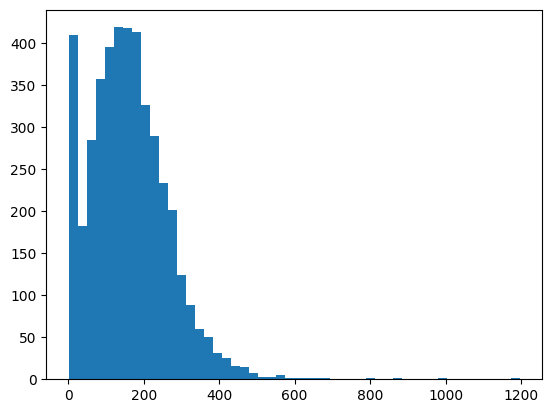

In [ ]:
lengths = []
for token_sequence in tqdm.tqdm(raw_datasets["train"]):
    token_sequence = token_sequence["text"]
    indices = tokenizer(token_sequence)["input_ids"]
    lengths += [len(indices)]

plt.hist(lengths, bins=50)
plt.show()

## Train the model.

Prepare the tokenization function.

In [ ]:
sequence_length = 256

def tokenize_function(example):
    tokenized_example = tokenizer(
        example["text"],
        truncation=True,
        padding=True,
        max_length=sequence_length,
    )
    return {
        "input_ids": tokenized_example["input_ids"]
    }

# Check a sample.
token_sequence = raw_datasets["train"][0]
print(token_sequence)
tokenized = tokenize_function(token_sequence)
assert list(tokenized.keys()) == ["input_ids"], list(tokenized.keys())
print(tokenized)

{'text': 'NYARLATHOTEP'}
{'input_ids': [40, 51, 27, 44, 38, 27, 1565, 41, 46, 31, 42]}


Create the tokenized dataset.

In [ ]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True, remove_columns=raw_datasets["train"].column_names)

# Check a sample.
tokenized = tokenized_datasets["train"][0]
assert list(tokenized.keys()) == ["input_ids"], list(tokenized.keys())
print(tokenized)

{'input_ids': [40, 51, 27, 44, 38, 27, 1565, 41, 46, 31, 42, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Instantiate a data collator.

In [ ]:
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

Create the model.

In [ ]:
model_config = GPT2Config(
    vocab_size=tokenizer.vocab_size,
    pad_token_id=tokenizer.pad_token_id,
    n_ctx=sequence_length,
    n_embd=512,
    n_head=8,
    n_layer=6,
    n_positions=sequence_length,
)
#model = GPT2LMHeadModel(model_config)
model = GPT2LMHeadModel.from_pretrained("gpt2")
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

## Test the data collator and the model.

input_ids: tensor([[  35,  260,  172, 1620, 2436,  118,  271,  113,  670,    9,  195,  113,
          127, 2901, 1431,   11,  184, 1518,   72, 4080,  127, 1211,   11, 1357,
           53, 4854,  103, 1045,  113,  399,  102,  226, 1514,  225,  930,  108,
          127, 2519,   53,  448,  102, 3074, 3651,  135,  103,  725, 2861, 4806,
           24,   53, 4806,   75, 1038,  381,  115,  102,  156,   10,  221,  294,
         2562,    9,  476,   53, 4806,  109,  802,  122, 4530,  342,   92,   93,
          325,  750, 3381,  109,  870,  103,   93,  340,   11,   35, 1620,  128,
           93,  873,  726,  332,  152, 2409,  102,  281, 1450, 1791,    9,  102,
         1858,  912,   66,  379,  102,  279, 3549,   55,  286,  182,  124,  183,
         2074,  919,  118, 4535,  105,  254,  212, 1488,  111,  807,  128,  112,
          132,  527,   11,   27, 1242,  103,  928,  530, 1510,  127,  490,   93,
          463,    9,  102,  181,  103,   93, 2729, 1382,   93, 1412, 3174, 3890,
          337,  4

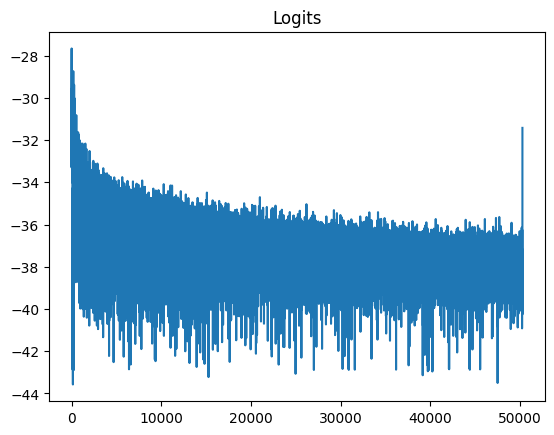

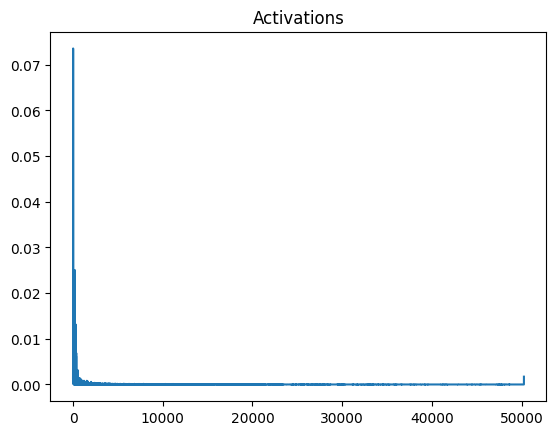

In [ ]:
inputs = [tokenized_datasets["train"][2]]
inputs = data_collator(inputs)
assert list(inputs.keys()) == ["input_ids", "attention_mask", "labels"], list(inputs.keys())
print("input_ids:", inputs["input_ids"])
print("")

outputs = model(**inputs)
assert list(outputs.keys()) == ["loss", "logits", "past_key_values"], list(outputs.keys())
print("logits:", outputs["logits"])

plt.plot(outputs["logits"].detach().numpy()[0][0])
plt.title("Logits")
plt.show()
plt.close()

activations = torch.nn.functional.softmax(outputs["logits"], dim=-1)
plt.plot(activations.detach().numpy()[0][0])
plt.title("Activations")
plt.show()
plt.close()

---

## Run the training.


In [ ]:
# Get the output directory with timestamp.
output_path = "output"

# Create the trainer.
print("Creating trainer...")
training_args = TrainingArguments(
    output_dir=output_path,
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_device_train_batch_size=8,
    prediction_loss_only=False,
)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
)

# Train the model.
trainer.train()

# Save the tokenizer.
tokenizer.save_pretrained(output_path)

# Save the model.
model.save_pretrained(output_path)

Creating trainer...


Step,Training Loss
500,6.687700
1000,6.232600
1500,5.989100
2000,5.791500
2500,5.598000
3000,5.460900
3500,5.339600
4000,5.259200
4500,5.204800
5000,5.159600


input_ids: tensor([[  35,  260,  172, 1620, 2436,  118,  271,  113,  670,    9,  195,  113,
          127, 2901, 1431,   11,  184, 1518,   72, 4080,  127, 1211,   11, 1357,
           53, 4854,  103, 1045,  113,  399,  102,  226, 1514,  225,  930,  108,
          127, 2519,   53,  448,  102, 3074, 3651,  135,  103,  725, 2861, 4806,
           24,   53, 4806,   75, 1038,  381,  115,  102,  156,   10,  221,  294,
         2562,    9,  476,   53, 4806,  109,  802,  122, 4530,  342,   92,   93,
          325,  750, 3381,  109,  870,  103,   93,  340,   11,   35, 1620,  128,
           93,  873,  726,  332,  152, 2409,  102,  281, 1450, 1791,    9,  102,
         1858,  912,   66,  379,  102,  279, 3549,   55,  286,  182,  124,  183,
         2074,  919,  118, 4535,  105,  254,  212, 1488,  111,  807,  128,  112,
          132,  527,   11,   27, 1242,  103,  928,  530, 1510,  127,  490,   93,
          463,    9,  102,  181,  103,   93, 2729, 1382,   93, 1412, 3174, 3890,
          337,  4

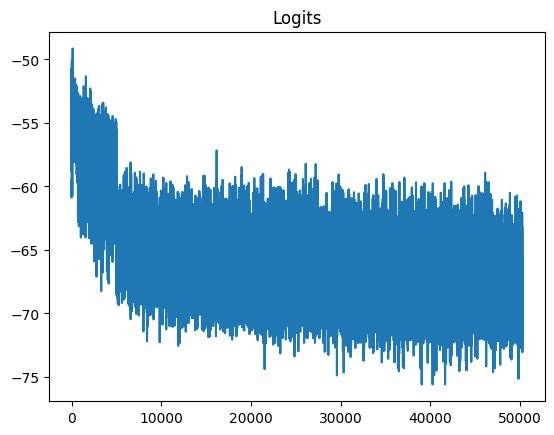

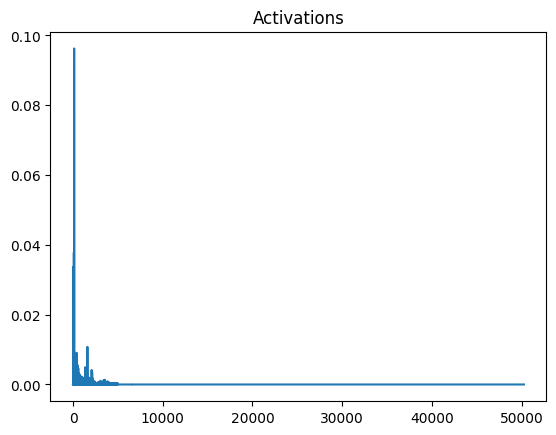

In [ ]:
inputs = [tokenized_datasets["train"][2]]
inputs = data_collator(inputs)
assert list(inputs.keys()) == ["input_ids", "attention_mask", "labels"], list(inputs.keys())
print("input_ids:", inputs["input_ids"])
print("")

outputs = model(**inputs.to("cuda:0"))
assert list(outputs.keys()) == ["loss", "logits", "past_key_values"], list(outputs.keys())
print("logits:", outputs["logits"])

plt.plot(outputs["logits"].cpu().detach().numpy()[0][0])
plt.title("Logits")
plt.show()
plt.close()

activations = torch.nn.functional.softmax(outputs["logits"], dim=-1)
plt.plot(activations.cpu().detach().numpy()[0][0])
plt.title("Activations")
plt.show()
plt.close()

## How to generate.

In [ ]:
# Encode the conditioning tokens.
input_ids = tokenizer.encode("The most merciful thing in the world, I think, is the inability of the human mind to correlate all its contents.", return_tensors="pt").cuda()
print(input_ids)

# Generate more tokens.
generated_ids = model.generate(
    input_ids,
    max_length=100,
    do_sample=True,
    temperature=0.5
)
generated_sequence = tokenizer.decode(generated_ids[0], clean_up_tokenization_spaces=True)
print(generated_sequence)

#Thank you!